In [211]:
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle

In [212]:
def plot_hsv(hist_h, hist_s, hist_v):
    # Criar a grade de subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plotar o primeiro gráfico
    axs[0].plot(hist_h)
    axs[0].set_title('H')

    # Plotar o segundo gráfico
    axs[1].plot(hist_s)
    axs[1].set_title('S')

    # Plotar o terceiro gráfico
    axs[2].plot(hist_v)
    axs[2].set_title('V')

    # Ajustar layout para evitar sobreposição de rótulos
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()

In [213]:
def plot_diff(hist):
    # Calcular a primeira derivada do histograma
    primeira_derivada = np.diff(hist.squeeze())
    primeira_derivada = np.convolve(primeira_derivada.squeeze(), np.ones(10)/10, mode='valid')

    # Calcular a segunda derivada do histograma
    segunda_derivada = np.diff(primeira_derivada)
    segunda_derivada = np.convolve(segunda_derivada.squeeze(), np.ones(10)/10, mode='valid')

    # Plotar os gráficos
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(hist)
    plt.title('Histograma Original')

    plt.subplot(1, 3, 2)
    plt.plot(primeira_derivada)
    plt.title('Primeira Derivada')

    plt.subplot(1, 3, 3)
    plt.plot(segunda_derivada)
    plt.title('Segunda Derivada')

    plt.tight_layout()
    plt.show()

In [214]:
def find_path(img, tolerancia_h, tolerancia_s, tolerancia_v, h_min=0, h_max=0, s_min=0, s_max=0, v_min=0, v_max=0, usar_perfil=False):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Definir o intervalo de cores para o chão (mais restrito)
    # Calcular o histograma da matiz (H)
    hist_h = cv2.calcHist([hsv], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [256], [0, 256])

    hist_h = np.convolve(hist_h.squeeze(), np.array([0, 1, 1, 1, 1, 1, 0]) / 5 , mode='valid')
    hist_s = np.convolve(hist_s.squeeze(), np.ones(5)/5, mode='valid')
    hist_v = np.convolve(hist_v.squeeze(), np.ones(5)/5, mode='valid')
    # Encontrar o valor de matiz (H) mais comum
    valor_h_comum = np.argmax(hist_h)
    valor_s_comum = np.argmax(hist_s)
    valor_v_comum = np.argmax(hist_v)
    # Definir os limites do intervalo de cor baseados no valor de matiz (H) mais comum
    if not usar_perfil:
        h_min = max(0, valor_h_comum - tolerancia_h)
        h_max = min(255, valor_h_comum + tolerancia_h)
        s_min = max(0, valor_s_comum - tolerancia_s)
        s_max = min(255, valor_s_comum + tolerancia_s)
        v_min = max(0, valor_v_comum - tolerancia_v)
        v_max = min(255, valor_v_comum + tolerancia_v)

    imagem_blur = cv2.GaussianBlur(hsv, (13, 13), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (11, 11), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (7, 7), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (5, 5), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (3, 3), 0)

    lowerb = np.array([h_min, s_min, v_min])
    upperb = np.array([h_max, s_max, v_max])

    # Criar a máscara usando os limites do intervalo de cor
    mascara = cv2.inRange(hsv, lowerb, upperb)

    kernel = np.ones((3,3), np.uint8)
    imagem_dilatada = cv2.dilate(mascara, kernel, iterations=8)

    kernel = np.ones((3,3), np.uint8)
    imagem_erodida = cv2.erode(imagem_dilatada, kernel, iterations=10)
    imagem_invertida = cv2.bitwise_not(imagem_erodida)

    contorno = cv2.bitwise_and(img, img, mask=imagem_invertida)
    #plot_hsv(hist_h, hist_s, hist_v)
    # plot_diff(hist_h)
    # plot_diff(hist_s)
    # plot_diff(hist_v)
    #print("H:",valor_h_comum*360/255,"S:",valor_s_comum*100/255,"V:",valor_h_comum*100/255)
    plt.figure()
    plt.imshow(contorno, cmap="grey")
    plt.axis('off')
    return h_min, h_max, s_min, s_max, v_min, v_max

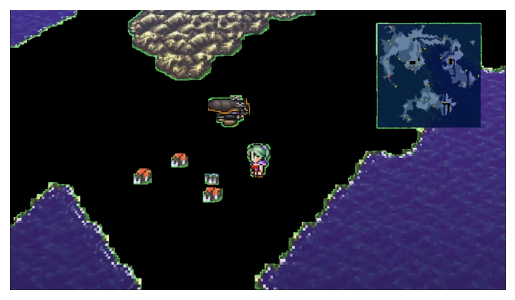

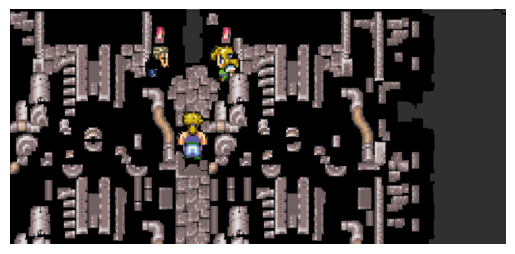

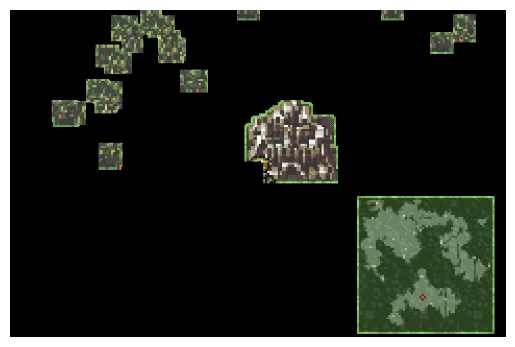

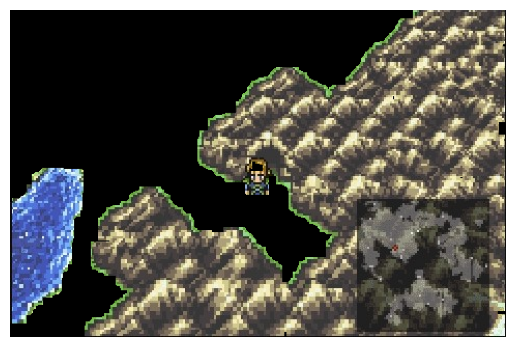

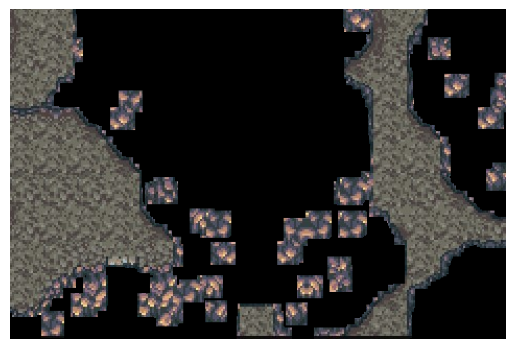

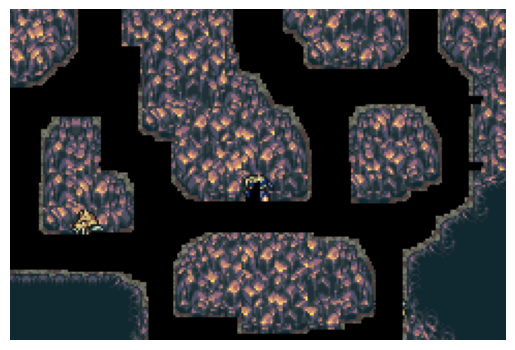

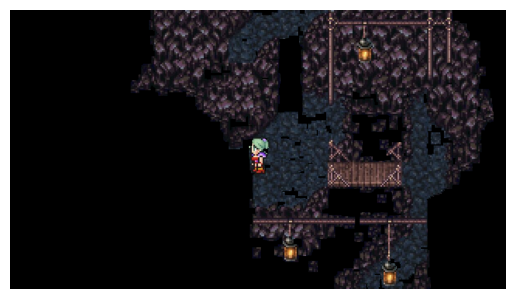

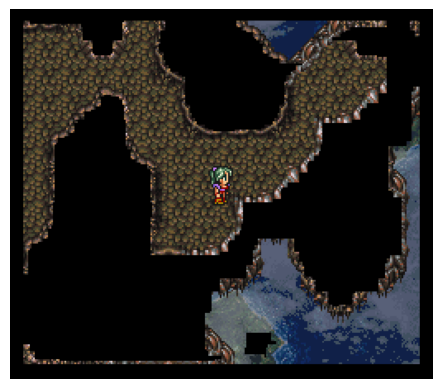

In [215]:
dicionario = {
    'Planicie': '..\\FFVI\\Maps\\planicie.jpg',
    'Planicie2': '..\\FFVI\\Maps\\fabrica.jpg',
    'Planicie3': '..\\FFVI\\Maps\\planicie3.jpg',
    'CavernaExt': '..\\FFVI\\Maps\\caverna_exterior.jpg',
    'CavernaInt': '..\\FFVI\\Maps\\caverna_interior.jpg',
    'CavernaInt2': '..\\FFVI\\Maps\\caverna_interior2.jpg',
    'CavernaInt3': '..\\FFVI\\Maps\\caverna_interior3.jpg',
    'azysla': '..\\FFVI\\Maps\\azysla.jpg',
}

for i in dicionario.values():
    original_image = Image.open(i)
    cv2_img = np.array(original_image)
    find_path(cv2_img, 50, 50, 50)

In [216]:
def save_color_profile(image_path, profile_name, h_min, h_max, s_min, s_max, v_min, v_max, save_directory='color_profiles'):
    # Carregar a imagem
    image = Image.open(image_path)
    image = image.convert('RGB')
    
    # Converter a imagem para HSV
    hsv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
    
    # Calcular os histogramas
    hist_h = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    
    # Normalizar os histogramas
    hist_h = hist_h / hist_h.sum()
    hist_s = hist_s / hist_s.sum()
    hist_v = hist_v / hist_v.sum()
    
    # Criar o perfil de cores
    color_profile = {
        'hist_h': hist_h,
        'hist_s': hist_s,
        'hist_v': hist_v,
        'h_min': h_min,
        'h_max': h_max,
        's_min': s_min,
        's_max': s_max,
        'v_min': v_min,
        'v_max': v_max
    }
    
    # Criar o diretório de perfis de cores, se não existir
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Salvar o perfil de cores
    profile_path = os.path.join(save_directory, f'{profile_name}.pkl')
    with open(profile_path, 'wb') as f:
        pickle.dump(color_profile, f)
    
    print(f'Perfil de cores salvo em: {profile_path}')


In [217]:
def compare_color_profile(image_path, save_directory='color_profiles'):
    # Carregar a imagem
    image = Image.open(image_path)
    image = image.convert('RGB')
    
    # Converter a imagem para HSV
    hsv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
    
    # Calcular os histogramas
    hist_h = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    
    # Normalizar os histogramas
    hist_h = hist_h / hist_h.sum()
    hist_s = hist_s / hist_s.sum()
    hist_v = hist_v / hist_v.sum()
    
    # Carregar perfis de cores salvos
    profiles = []
    for filename in os.listdir(save_directory):
        if filename.endswith('.pkl'):
            with open(os.path.join(save_directory, filename), 'rb') as f:
                profiles.append((filename, pickle.load(f)))
    
    # Comparar a imagem com cada perfil de cores
    max_correlation = -1
    best_match = None
    best_profile = None
    for profile_name, profile in profiles:
        corr_h = cv2.compareHist(hist_h, profile['hist_h'], cv2.HISTCMP_CORREL)
        corr_s = cv2.compareHist(hist_s, profile['hist_s'], cv2.HISTCMP_CORREL)
        corr_v = cv2.compareHist(hist_v, profile['hist_v'], cv2.HISTCMP_CORREL)
        
        # Calcular a média das correlações
        mean_correlation = (corr_h + corr_s + corr_v) / 3
        if mean_correlation > max_correlation:
            max_correlation = mean_correlation
            best_match = profile_name
            best_profile =  profile
    
    return best_match, best_profile['h_min'], best_profile['h_max'], best_profile['s_min'], best_profile['s_max'], best_profile['v_min'], best_profile['v_max']


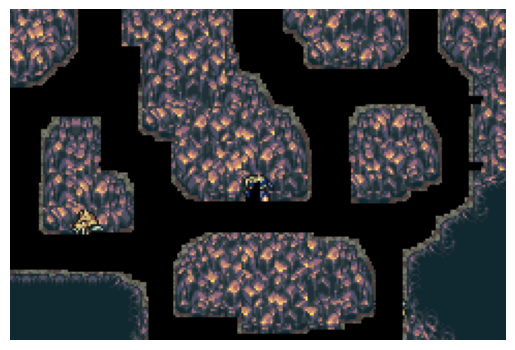

In [229]:
treino = {
    'planicie': 'FFVI\\Maps\\planicie.jpg',
    'fabrica': 'FFVI\\Maps\\fabrica.jpg',
    'caverna_clara': 'FFVI\\Maps\\caverna_interior2.jpg',
    'caverna_escura': 'FFVI\\Maps\\caverna_interior3.jpg',
}

t_h = 50
t_s = 50
t_v = 50
nome = 'caverna_clara'
original_image = Image.open(treino[nome])
cv2_img = np.array(original_image)
h_min, h_max, s_min, s_max, v_min, v_max = find_path(cv2_img, t_h, t_s, t_v)

In [230]:
save_color_profile(treino[nome], nome,  h_min, h_max, s_min, s_max, v_min, v_max)

Perfil de cores salvo em: color_profiles\caverna_clara.pkl


(38, 138, 0, 82, 10, 110)

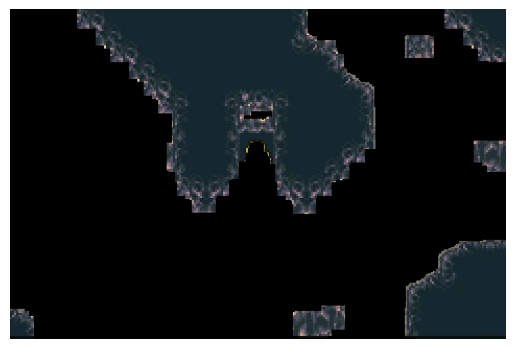

In [231]:
_, h_min, h_max, s_min, s_max, v_min, v_max = compare_color_profile('FFVI\\Maps\\caverna_interior.jpg')
original_image = Image.open('FFVI\\Maps\\caverna_interior.jpg')
cv2_img = np.array(original_image)
find_path(cv2_img, t_h, t_s, t_v, h_min, h_max, s_min, s_max, v_min, v_max, True)